In [2]:
!pip install haversine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from haversine import haversine
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [7]:
data = pd.read_csv('/content/train.csv')
data.set_index('id',inplace=True)
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0


In [ ]:
data.shape

(1458644, 10)

In [ ]:
data.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [ ]:
pd.set_option("display.float_format", "{:.2f}".format)
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [ ]:
data = data.loc[data['trip_duration']<20000]

<Axes: xlabel='vendor_id', ylabel='count'>

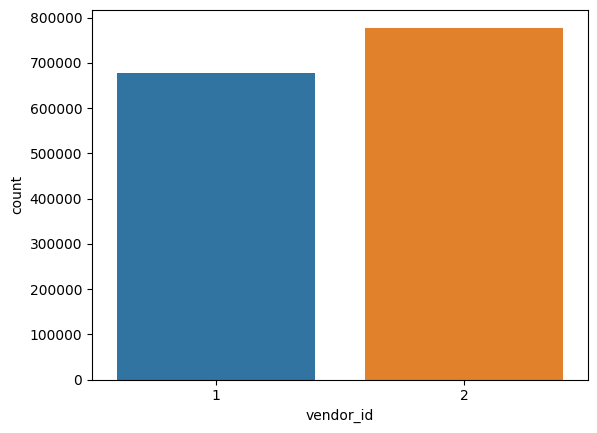

In [ ]:
sns.countplot(data=data,x='vendor_id')

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')

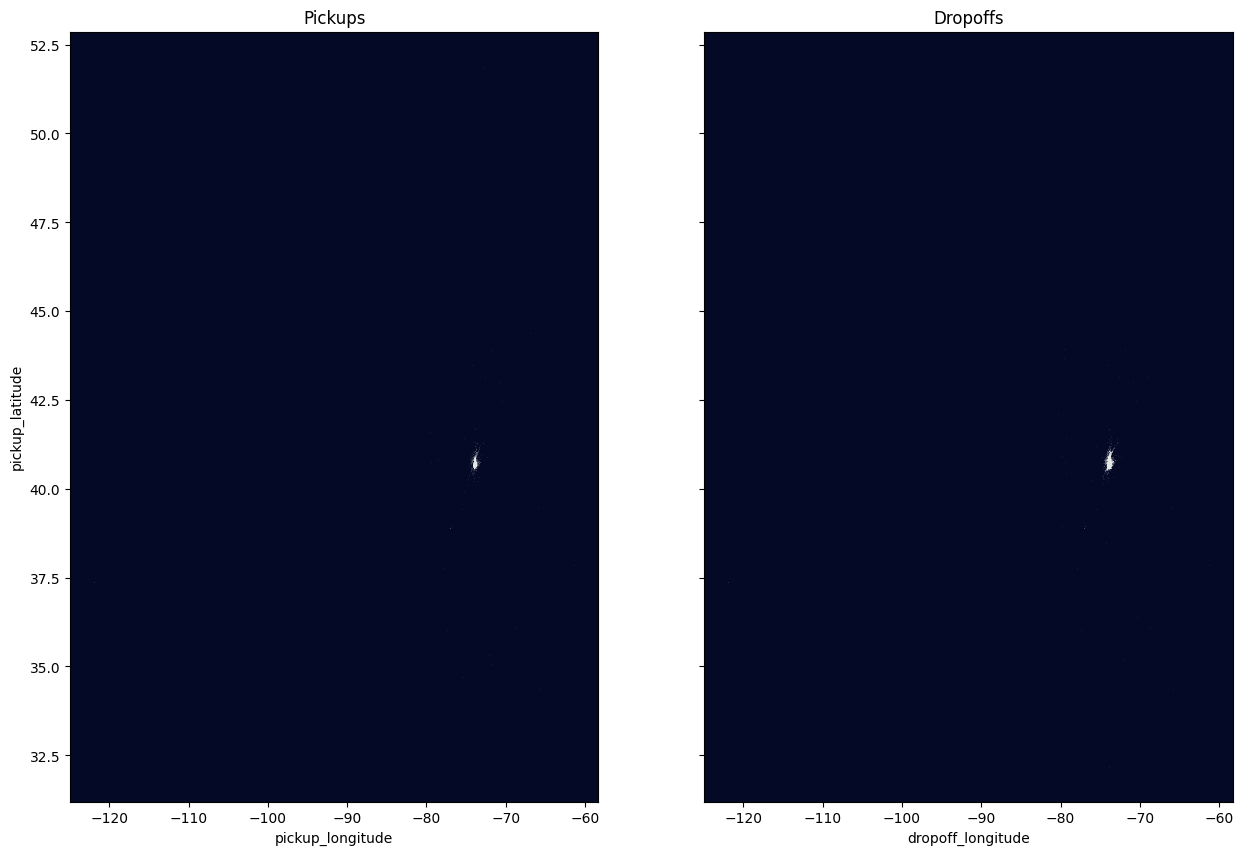

In [ ]:
 f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

 sns.scatterplot(data=data,x='pickup_longitude', y='pickup_latitude',color='#F2F7F2', ax=ax1,s=.07, alpha=.6)
 ax1.set_title("Pickups")
 ax1.set_facecolor('#040926')

 sns.scatterplot(data=data,x='dropoff_longitude', y='dropoff_latitude',color='#F2F7F2', ax=ax2,s=.07, alpha=.6)
 ax2.set_title("Dropoffs")
 ax2.set_facecolor('#040926')
 plt.show()

In [ ]:
data = data.loc[(data['pickup_latitude'] >= 40.637044) & (data['pickup_latitude'] <= 40.855256)]
data = data.loc[(data['pickup_longitude'] >= -74.035735) & (data['pickup_longitude'] <= -73.770272)]
data = data.loc[(data['dropoff_latitude'] >= 40.637044) & (data['dropoff_latitude'] <= 40.855256)]
data = data.loc[(data['dropoff_longitude'] >= -74.035735) & (data['dropoff_longitude'] <= -73.770272)]
data.shape

(1438064, 10)

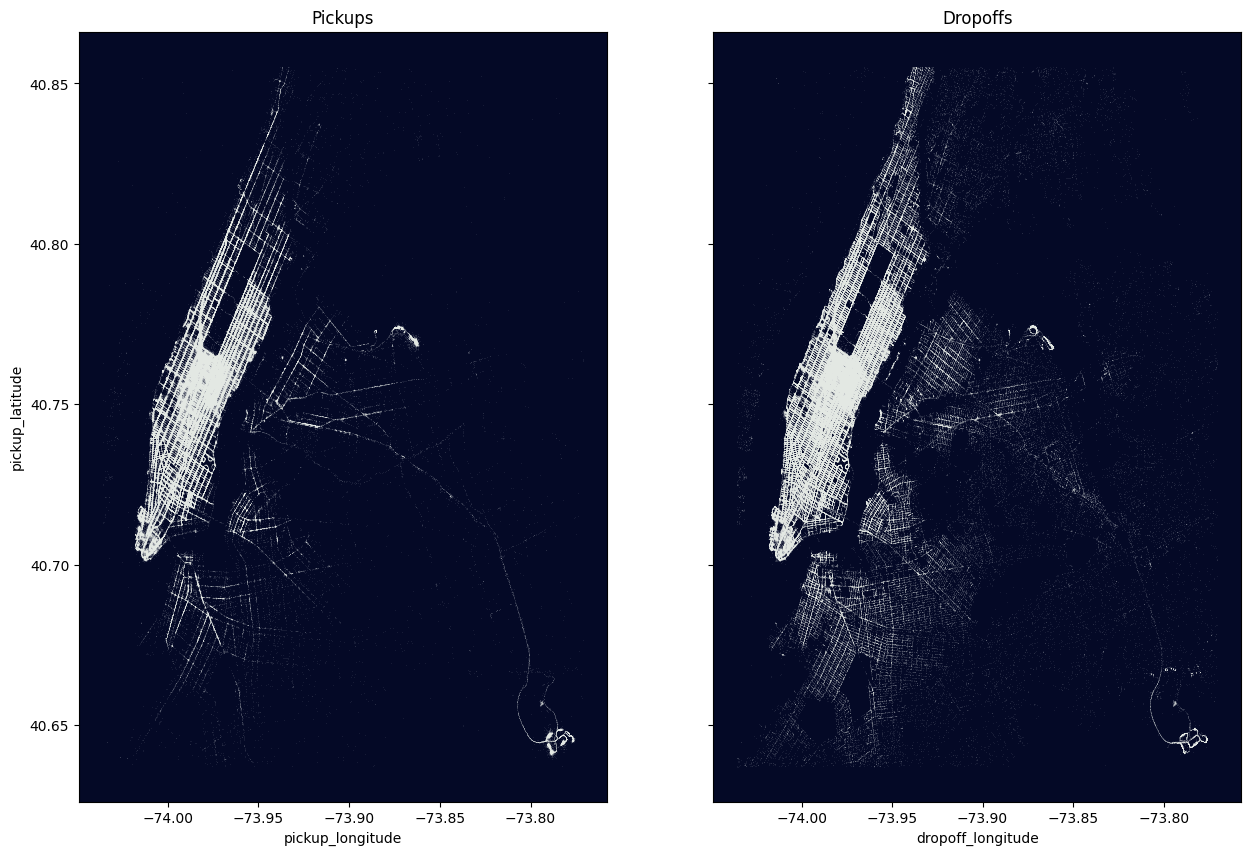

In [ ]:
 f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

 sns.scatterplot(data=data,x='pickup_longitude', y='pickup_latitude',color='#F2F7F2', ax=ax1,s=.07, alpha=.6)
 ax1.set_title("Pickups")
 ax1.set_facecolor('#040926')

 sns.scatterplot(data=data,x='dropoff_longitude', y='dropoff_latitude',color='#F2F7F2', ax=ax2,s=.07, alpha=.6)
 ax2.set_title("Dropoffs")
 ax2.set_facecolor('#040926')
 plt.show()

In [ ]:
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['day_of_week'] = data['day_of_week'].map(lambda x: day_names[x])
data['day_of_week']

id
id2875421       Monday
id2377394       Sunday
id3858529      Tuesday
id3504673    Wednesday
id2181028     Saturday
               ...    
id2376096       Friday
id1049543       Sunday
id2304944       Friday
id2714485      Tuesday
id1209952      Tuesday
Name: day_of_week, Length: 1438064, dtype: object

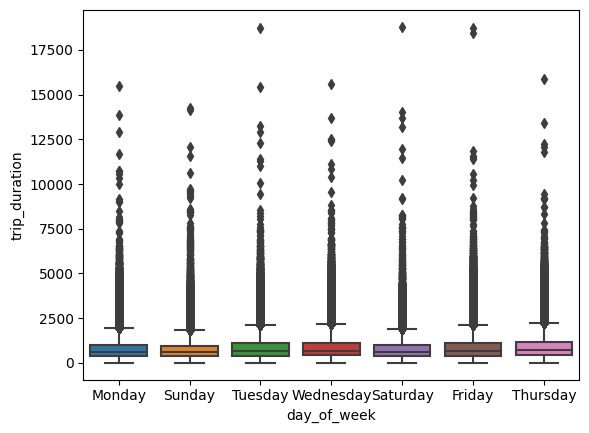

In [ ]:
sns.boxplot(data=data,x='day_of_week',y='trip_duration')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

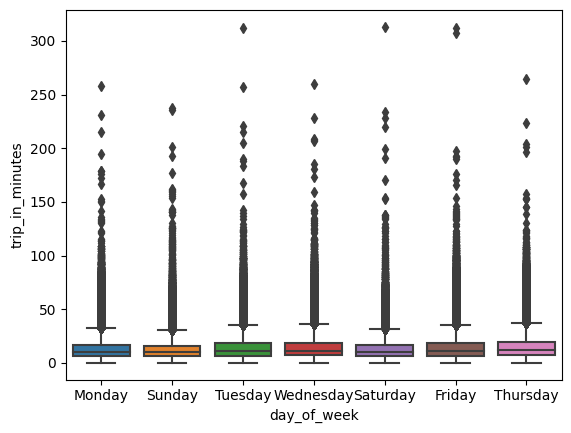

In [ ]:
data['trip_in_minutes'] = data['trip_duration']/60
sns.boxplot(data=data,x='day_of_week',y='trip_in_minutes')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

<Axes: xlabel='pickup_hour', ylabel='count'>

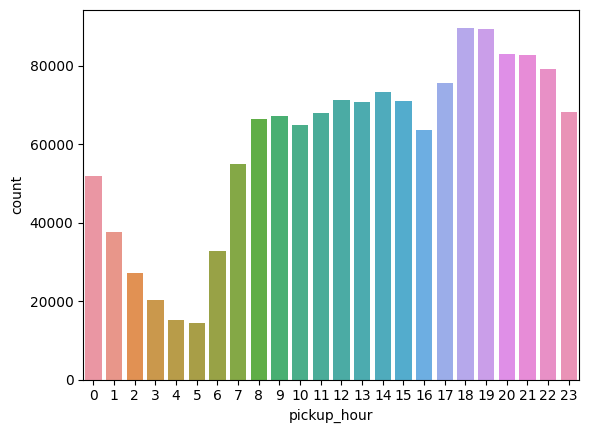

In [ ]:
#Check the rush hour of the day

data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_hour'].head()
sns.countplot(data=data,x='pickup_hour')

<Axes: xlabel='pickup_month', ylabel='count'>

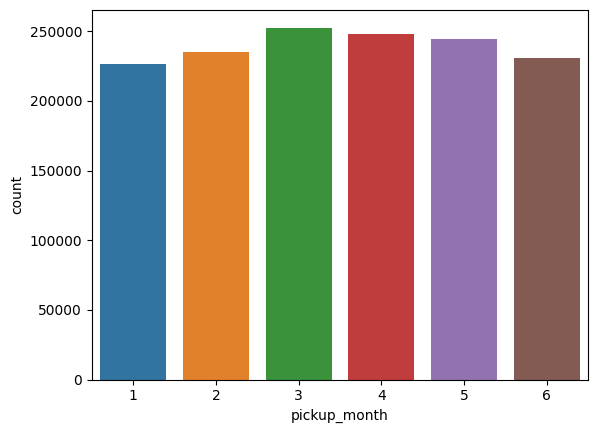

In [ ]:
#Checking the month-wise pickup rate

data['pickup_month'] = data['pickup_datetime'].dt.month

sns.countplot(data=data,x='pickup_month')

<Axes: xlabel='date', ylabel='count'>

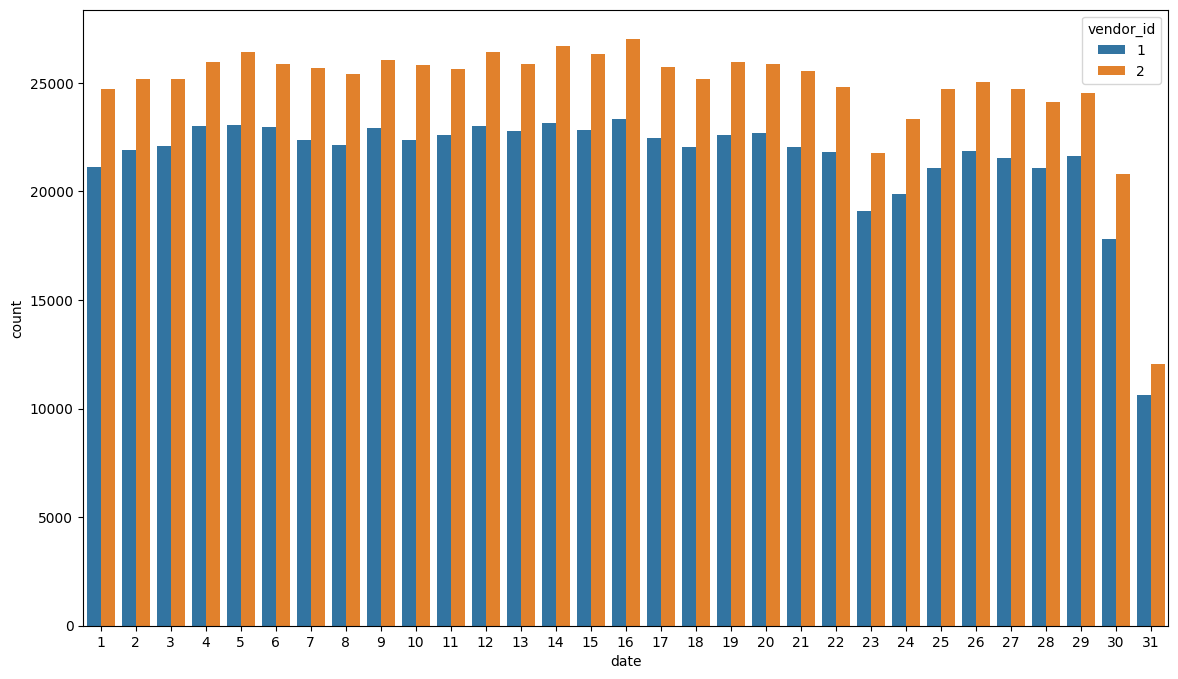

In [ ]:
data['date'] = data['pickup_datetime'].dt.day
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='date',hue='vendor_id')

<Axes: xlabel='day_of_week', ylabel='count'>

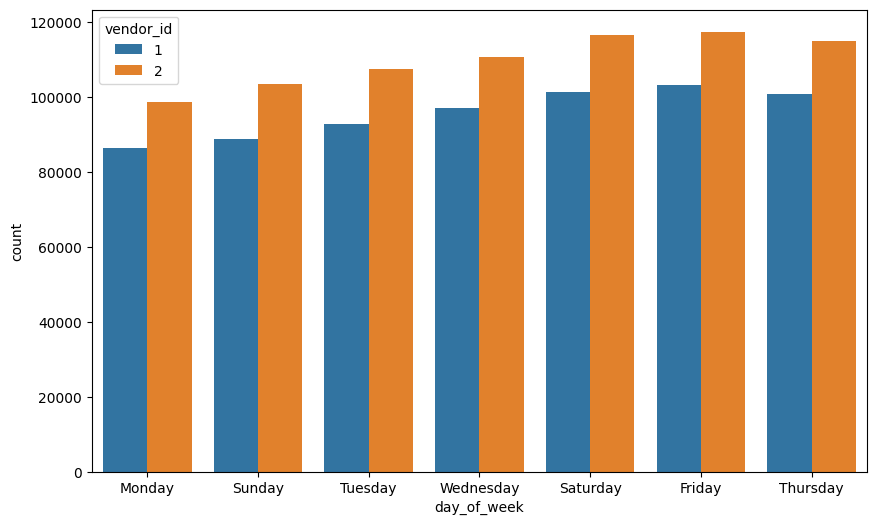

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='day_of_week',hue='vendor_id')

In [ ]:
#converting latitude and longitude to clusters as cant be used as it is in linear regression modelling
pickup_coordinates = data[['pickup_latitude','pickup_longitude']]
dropoff_coordinates = data[['dropoff_latitude','dropoff_longitude']]

n_clusters = 5

pickup_kmeans = KMeans(n_clusters=n_clusters,random_state=42)
data['pickup_cluster_label'] = pickup_kmeans.fit_predict(pickup_coordinates)

dropoff_kmeans = KMeans(n_clusters=n_clusters,random_state=42)
data['dropoff_cluster_label'] = dropoff_kmeans.fit_predict(dropoff_coordinates)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
data['haversine_distance'] = data.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])),axis=1)
data['haversine_distance'].head(10)

id
id2875421   1.50
id2377394   1.81
id3858529   6.39
id3504673   1.49
id2181028   1.19
id0801584   1.10
id1813257   1.33
id1324603   5.71
id1301050   1.31
id0012891   5.12
Name: haversine_distance, dtype: float64

<BarContainer object of 7 artists>

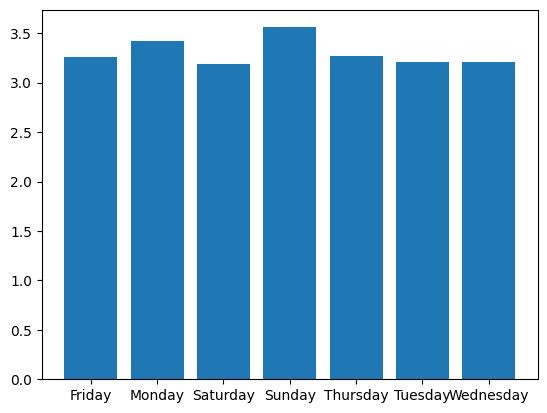

In [ ]:
averageDis = data.groupby('day_of_week')['haversine_distance'].mean()
plt.bar(averageDis.index,averageDis.values)

<Axes: xlabel='day_of_week', ylabel='haversine_distance'>

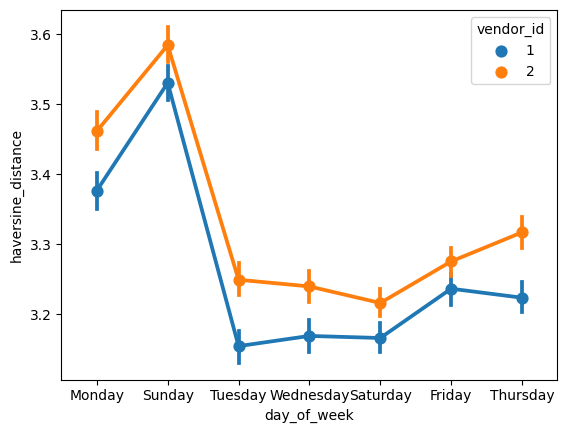

In [ ]:
sns.pointplot(x='day_of_week',y='haversine_distance',hue='vendor_id',data=data)

<ipython-input-24-7e65b5ee9bff>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,fmt='.2f')


Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'day_of_week', 'pickup_hour', 'pickup_month', 'date',
       'pickup_cluster_label', 'dropoff_cluster_label', 'haversine_distance'],
      dtype='object')

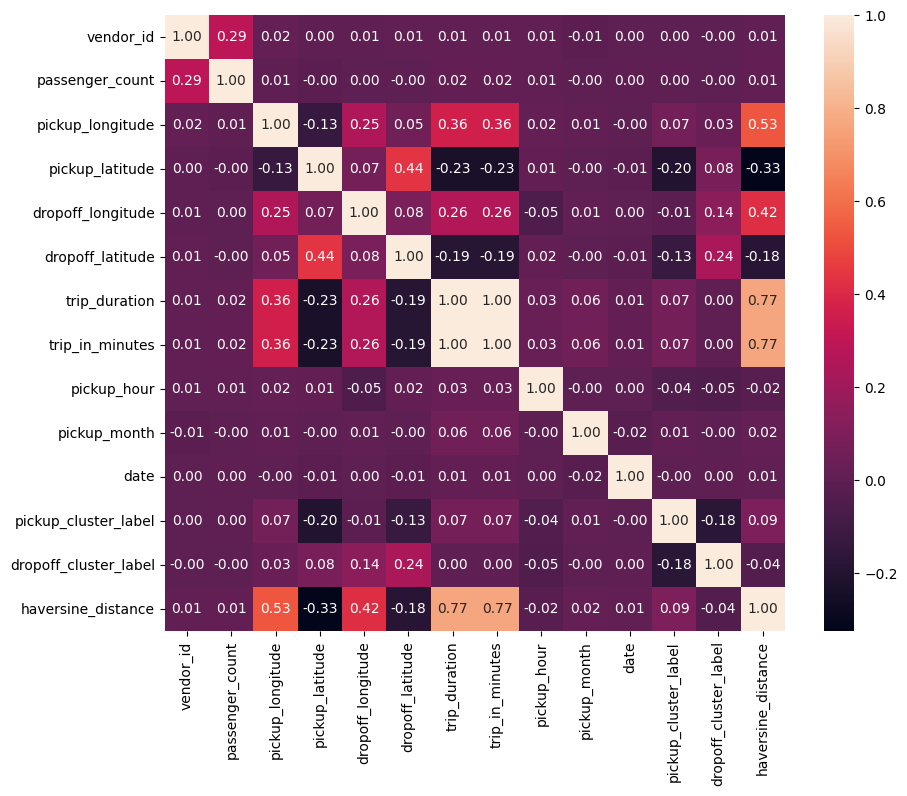

In [ ]:
data.describe()
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),annot=True,fmt='.2f')
data.drop(['trip_in_minutes','pickup_datetime','dropoff_datetime'],axis=1,inplace=True)
data.columns

In [ ]:
from sklearn.linear_model import LinearRegression

y = data['trip_duration']
X = data.drop(['trip_duration'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
model = LinearRegression()

model.fit(X_train,y_train)

LinearRegression()

In [ ]:
X.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'pickup_month',
       'date', 'pickup_cluster_label', 'dropoff_cluster_label',
       'haversine_distance', 'vendor_id_1', 'vendor_id_2',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [ ]:
ypred = model.predict(X_test)

print("RMSE: ",np.sqrt(mean_squared_error(y_test,ypred)))

RMSE:  402.35499291145453


In [ ]:
adamodel = AdaBoostRegressor()
adamodel.fit(X_train,y_train)

ypred = adamodel.predict(X_test)

print("RMSE: ",np.sqrt(mean_squared_error(y_test,ypred)))

RMSE:  515.7540998350785
